# 工具函数

In [2]:
#import talib
import numpy as np
import pandas as pd
import empyrical
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import datetime
import re
import copy
import pickle



# 衍生信号
def create_signal_long_short(yvalid_df):
    yvalid = yvalid_df['yvalid']
    # 无信号Signal_0，模拟买入持有
    yvalid_df['Signal_0'] = [1 for i in range(len(yvalid))]

    # 【多空双向】
    # 数值类信号：Signal_1: Positive

    yvalid_df['Signal_2'] = (yvalid>0.001)*1 + (yvalid<-0.001)*-1


    # 布林带类信号
    boll_temp_df = pd.DataFrame()
    boll_temp_df['yvalid'] = yvalid
    boll_temp_df['MA20'] = boll_temp_df['yvalid'].rolling(20).mean()
    boll_temp_df['MA60'] = boll_temp_df['yvalid'].rolling(60).mean()
    boll_temp_df['std20'] = boll_temp_df['yvalid'].rolling(20).std()
    boll_temp_df['std60'] = boll_temp_df['yvalid'].rolling(60).std()
    boll_temp_df['p_boll_20_1'] = (boll_temp_df['yvalid'] > (boll_temp_df['MA20']+boll_temp_df['std20']*1))*1
    boll_temp_df['p_boll_20_2'] = (boll_temp_df['yvalid'] > (boll_temp_df['MA20']+boll_temp_df['std20']*2))*1
    boll_temp_df['p_boll_60_1'] = (boll_temp_df['yvalid'] > (boll_temp_df['MA60']+boll_temp_df['std60']*1))*1
    boll_temp_df['p_boll_60_2'] = (boll_temp_df['yvalid'] > (boll_temp_df['MA60']+boll_temp_df['std60']*2))*1    
    boll_temp_df['n_boll_20_1'] = (boll_temp_df['yvalid'] < (boll_temp_df['MA20']-boll_temp_df['std20']*1))*-1
    boll_temp_df['n_boll_20_2'] = (boll_temp_df['yvalid'] < (boll_temp_df['MA20']-boll_temp_df['std20']*2))*-1
    boll_temp_df['n_boll_60_1'] = (boll_temp_df['yvalid'] < (boll_temp_df['MA60']-boll_temp_df['std60']*1))*-1
    boll_temp_df['n_boll_60_2'] = (boll_temp_df['yvalid'] < (boll_temp_df['MA60']-boll_temp_df['std60']*2))*-1    
    
    yvalid_df['Signal_6'] = boll_temp_df['p_boll_20_1']+boll_temp_df['n_boll_20_1']

    yvalid_df['Signal_8'] = boll_temp_df['p_boll_60_1']+boll_temp_df['n_boll_60_1']

    

    
    return yvalid_df

# 读取数据 准备因子

In [12]:
with open('XX_store_no_rank_bench1_add3_ts40.pkl','rb') as f:
    [X_0,X_0_add,X_1,X_1_add,X_2,X_2_add,X_3,X_3_add] = pickle.load(f)

In [13]:
with open('yy_store_no_rank_bench1_add3_ts40.pkl','rb') as f:
    [y_0,y_0_add,y_1,y_1_add,y_2,y_2_add,y_3,y_3_add] = pickle.load(f)

In [14]:
with open('test_index_dict_store_no_rank_bench1_add3_ts40.pkl','rb') as f:
    [test_index_dict_0,test_index_dict_0_add,
                 test_index_dict_1,test_index_dict_1_add,
                 test_index_dict_2,test_index_dict_2_add,
                 test_index_dict_3,test_index_dict_3_add] = pickle.load(f)

In [16]:
with open('index_dict_ori_9999_111因子1日.pkl','rb') as f:
    index_dict_ori_9999 = pickle.load(f)

In [15]:
print(X_0.shape,X_0_add.shape,X_1.shape,X_1_add.shape,X_2.shape,X_2_add.shape,X_3.shape,X_3_add.shape)
print(y_0.shape,y_0_add.shape,y_1.shape,y_1_add.shape,y_2.shape,y_2_add.shape,y_3.shape,y_3_add.shape)

(26526, 84) (28162, 84) (30006, 84) (31564, 84) (33399, 84) (35345, 84) (37076, 84) (38794, 84)
(26526,) (28162,) (30006,) (31564,) (33399,) (35345,) (37076,) (38794,)


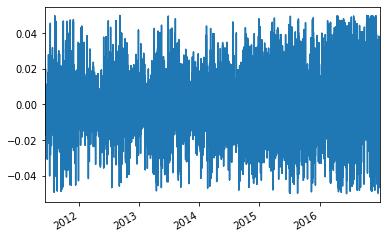

In [15]:
y_0.plot()

# cv5 常规训练 

In [11]:
# 每段数据的日期参数
# 每半年一段，分为8段

start_dte_0='2011-01-01'
train_end_0 = '2017-01-01'
test_end_0 = '2017-07-01'

start_dte_0_add='2011-07-01'
train_end_0_add = '2017-07-01'
test_end_0_add = '2017-12-31'

start_dte_1='2012-01-01'
train_end_1 = '2018-01-01'
test_end_1 = '2018-07-01'

start_dte_1_add='2012-07-01'
train_end_1_add = '2018-07-01'
test_end_1_add = '2018-12-31'

start_dte_2 ='2013-01-01'
train_end_2 = '2019-01-01'
test_end_2 = '2019-07-01'

start_dte_2_add ='2013-07-01'
train_end_2_add = '2019-07-01'
test_end_2_add = '2019-12-31'

start_dte_3 ='2014-01-01'
train_end_3 = '2020-01-01'
test_end_3 = '2020-07-01'

start_dte_3_add ='2014-07-01'
train_end_3_add = '2020-07-01'
test_end_3_add = '2020-12-29'

In [19]:
# 生成params————————————————————【控制参数范围】
import numpy as np
import pandas as pd

params_list = []
n_split = 5
#for max_depth in range(5,15,5):
for max_depth in [15]:
    #for eta in np.arange(0.01,0.05,0.01):
    for eta in [0.01]:
        #for colsample_bytree_and_subsample in np.arange(0.5,0.7,0.2):
        for colsample_bytree_and_subsample in [0.9]:
            #for min_child_weight in np.arange(20,90,20):
            for min_child_weight in [10]:
                params = params = {
                    'booster': 'gbtree',
                    'objective': 'reg:linear',
                    'gamma': 0,
                    'max_depth': max_depth,
                    'subsample': colsample_bytree_and_subsample,
                    'colsample_bytree': colsample_bytree_and_subsample,
                    'min_child_weight': min_child_weight,
                    'silent': 1,
                    'eta': eta,
                    'seed': 1000,  
                    'nthread': 6,
                }
                params_list.append(params)
len(params_list)

1

# 训练过程（最佳参数 all）

In [17]:
import warnings  
warnings.filterwarnings('ignore') 


import empyrical

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import datetime


from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit
import time 

corr_DF_ALL = pd.DataFrame()

# for params in [params_list[0]]:
for params in params_list:
    # 【=================训练0=================】
    rs = ShuffleSplit(n_splits=n_split, test_size=0.3, random_state=0)
    model=[]
    train_rmse = [] 
    var_rmse= [] 
    dt = {}
    X_train, X_test,y_train, y_test = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    for train_index, test_index in rs.split(X_0):
        X_train, X_test = X_0.iloc[train_index,:], X_0.iloc[test_index,:]
        y_train, y_test = y_0.iloc[train_index], y_0.iloc[test_index]
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dtest = xgb.DMatrix(X_test,label=y_test)
        watchlist = [(dtrain,'Train'),(dtest,'Val')]
        bst=xgb.train(params,dtrain,num_boost_round=2000,evals=watchlist,evals_result=dt, early_stopping_rounds=20)
        train_rmse.append(dt['Train']['rmse'][-1])
        var_rmse.append(dt['Val']['rmse'][-1])
        model.append(bst)

    # 预测，存储预测值
    test_target_dict_0 = {}
    for test_index_F in index_dict_ori_9999.keys():
        test_target_dict_0[test_index_F] = index_dict_ori_9999[test_index_F][['open_to_open','open_to_close']].loc[train_end_0:test_end_0]
    print('len(test_target_dict_0.keys())',len(test_target_dict_0.keys()))
    
    for test_index_F in test_index_dict_0.keys():
        yvalid_list=[]
        print('Predict processing',test_index_F)
        # valid data
        x_valid=test_index_dict_0[test_index_F][test_index_dict_0[test_index_F].columns]

        try:
            for m in model:
                dvalid = xgb.DMatrix(x_valid)
                yvalid_list.append(m.predict(dvalid))
            test_target_dict_0[test_index_F]['yvalid']=np.array([i for i in yvalid_list]).mean(axis=0)
            test_target_dict_0[test_index_F]['yvalid'].fillna(method='pad',inplace=True) 
        except:
            test_target_dict_0[test_index_F]['yvalid']=0
            
    # 【=================训练0  add=================】
    rs = ShuffleSplit(n_splits=n_split, test_size=0.3, random_state=0)
    model=[]
    train_rmse = [] 
    var_rmse= [] 
    dt = {}
    X_train, X_test,y_train, y_test = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    for train_index, test_index in rs.split(X_0_add):
        X_train, X_test = X_0_add.iloc[train_index,:], X_0_add.iloc[test_index,:]
        y_train, y_test = y_0_add.iloc[train_index], y_0_add.iloc[test_index]
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dtest = xgb.DMatrix(X_test,label=y_test)
        watchlist = [(dtrain,'Train'),(dtest,'Val')]
        bst=xgb.train(params,dtrain,num_boost_round=2000,evals=watchlist,evals_result=dt, early_stopping_rounds=20)
        train_rmse.append(dt['Train']['rmse'][-1])
        var_rmse.append(dt['Val']['rmse'][-1])
        model.append(bst)

    # 预测，存储预测值
    test_target_dict_0_add = {}
    for test_index_F in index_dict_ori_9999.keys():
        test_target_dict_0_add[test_index_F] = index_dict_ori_9999[test_index_F][['open_to_open','open_to_close']].loc[train_end_0_add:test_end_0_add]
    print('len(test_target_dict_0_add.keys())',len(test_target_dict_0_add.keys()))
    
    for test_index_F in test_index_dict_0_add.keys():
        yvalid_list=[]
        print('Predict processing',test_index_F)
        # valid data
        x_valid=test_index_dict_0_add[test_index_F][test_index_dict_0_add[test_index_F].columns]

        try:
            for m in model:
                dvalid = xgb.DMatrix(x_valid)
                yvalid_list.append(m.predict(dvalid))
            test_target_dict_0_add[test_index_F]['yvalid']=np.array([i for i in yvalid_list]).mean(axis=0)
            test_target_dict_0_add[test_index_F]['yvalid'].fillna(method='pad',inplace=True) 
        except:
            test_target_dict_0_add[test_index_F]['yvalid']=0
    
    
    # 【=================训练1=================】
    rs = ShuffleSplit(n_splits=n_split, test_size=0.3, random_state=0)
    model=[]
    train_rmse = [] 
    var_rmse= [] 
    dt = {}
    X_train, X_test,y_train, y_test = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    for train_index, test_index in rs.split(X_1):
        X_train, X_test = X_1.iloc[train_index,:], X_1.iloc[test_index,:]
        y_train, y_test = y_1.iloc[train_index], y_1.iloc[test_index]
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dtest = xgb.DMatrix(X_test,label=y_test)
        watchlist = [(dtrain,'Train'),(dtest,'Val')]
        bst=xgb.train(params,dtrain,num_boost_round=2000,evals=watchlist,evals_result=dt, early_stopping_rounds=20)
        train_rmse.append(dt['Train']['rmse'][-1])
        var_rmse.append(dt['Val']['rmse'][-1])
        model.append(bst)

    # 预测，存储预测值
    test_target_dict_1 = {}
    for test_index_F in index_dict_ori_9999.keys():
        test_target_dict_1[test_index_F] = index_dict_ori_9999[test_index_F][['open_to_open','open_to_close']].loc[train_end_1:test_end_1]
    print('len(test_target_dict_1.keys())',len(test_target_dict_1.keys()))
    
    for test_index_F in test_index_dict_1.keys():
        yvalid_list=[]
        print('Predict processing',test_index_F)
        # valid data
        x_valid=test_index_dict_1[test_index_F][test_index_dict_1[test_index_F].columns]

        try:
            for m in model:
                dvalid = xgb.DMatrix(x_valid)
                yvalid_list.append(m.predict(dvalid))
            test_target_dict_1[test_index_F]['yvalid']=np.array([i for i in yvalid_list]).mean(axis=0)
            test_target_dict_1[test_index_F]['yvalid'].fillna(method='pad',inplace=True) 
        except:
            test_target_dict_1[test_index_F]['yvalid']=0
        
        
    # 【=================训练1   add================】
    rs = ShuffleSplit(n_splits=n_split, test_size=0.3, random_state=0)
    model=[]
    train_rmse = [] 
    var_rmse= [] 
    dt = {}
    X_train, X_test,y_train, y_test = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    for train_index, test_index in rs.split(X_1_add):
        X_train, X_test = X_1_add.iloc[train_index,:], X_1_add.iloc[test_index,:]
        y_train, y_test = y_1_add.iloc[train_index], y_1_add.iloc[test_index]
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dtest = xgb.DMatrix(X_test,label=y_test)
        watchlist = [(dtrain,'Train'),(dtest,'Val')]
        bst=xgb.train(params,dtrain,num_boost_round=2000,evals=watchlist,evals_result=dt, early_stopping_rounds=20)
        train_rmse.append(dt['Train']['rmse'][-1])
        var_rmse.append(dt['Val']['rmse'][-1])
        model.append(bst)

    # 预测，存储预测值
    test_target_dict_1_add = {}
    for test_index_F in index_dict_ori_9999.keys():
        test_target_dict_1_add[test_index_F] = index_dict_ori_9999[test_index_F][['open_to_open','open_to_close']].loc[train_end_1_add:test_end_1_add]
    print('len(test_target_dict_1_add.keys())',len(test_target_dict_1_add.keys()))
    
    for test_index_F in test_index_dict_1_add.keys():
        yvalid_list=[]
        print('Predict processing',test_index_F)
        # valid data
        x_valid=test_index_dict_1_add[test_index_F][test_index_dict_1_add[test_index_F].columns]

        try:
            for m in model:
                dvalid = xgb.DMatrix(x_valid)
                yvalid_list.append(m.predict(dvalid))
            test_target_dict_1_add[test_index_F]['yvalid']=np.array([i for i in yvalid_list]).mean(axis=0)
            test_target_dict_1_add[test_index_F]['yvalid'].fillna(method='pad',inplace=True) 
        except:
            test_target_dict_1_add[test_index_F]['yvalid']=0
            
            
    # 【=================训练2=================】
    rs = ShuffleSplit(n_splits=n_split, test_size=0.3, random_state=0)
    model=[]
    train_rmse = [] 
    var_rmse= [] 
    dt = {}
    X_train, X_test,y_train, y_test = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    for train_index, test_index in rs.split(X_2):
        X_train, X_test = X_2.iloc[train_index,:], X_2.iloc[test_index,:]
        y_train, y_test = y_2.iloc[train_index], y_2.iloc[test_index]
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dtest = xgb.DMatrix(X_test,label=y_test)
        watchlist = [(dtrain,'Train'),(dtest,'Val')]
        bst=xgb.train(params,dtrain,num_boost_round=2000,evals=watchlist,evals_result=dt, early_stopping_rounds=20)
        train_rmse.append(dt['Train']['rmse'][-1])
        var_rmse.append(dt['Val']['rmse'][-1])
        model.append(bst)

    # 预测，存储预测值
    test_target_dict_2 = {}
    for test_index_F in index_dict_ori_9999.keys():
        test_target_dict_2[test_index_F] = index_dict_ori_9999[test_index_F][['open_to_open','open_to_close']].loc[train_end_2:test_end_2]
    print('len(test_target_dict_2.keys())',len(test_target_dict_2.keys()))
    
    for test_index_F in test_index_dict_2.keys():
        yvalid_list=[]
        print('Predict processing',test_index_F)
        # valid data
        x_valid=test_index_dict_2[test_index_F][test_index_dict_2[test_index_F].columns]

        try:
            for m in model:
                dvalid = xgb.DMatrix(x_valid)
                yvalid_list.append(m.predict(dvalid))
            test_target_dict_2[test_index_F]['yvalid']=np.array([i for i in yvalid_list]).mean(axis=0)
            test_target_dict_2[test_index_F]['yvalid'].fillna(method='pad',inplace=True) 
        except:
            test_target_dict_2[test_index_F]['yvalid']=0
            
            
    # 【=================训练2 add=================】
    rs = ShuffleSplit(n_splits=n_split, test_size=0.3, random_state=0)
    model=[]
    train_rmse = [] 
    var_rmse= [] 
    dt = {}
    X_train, X_test,y_train, y_test = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    for train_index, test_index in rs.split(X_2_add):
        X_train, X_test = X_2_add.iloc[train_index,:], X_2_add.iloc[test_index,:]
        y_train, y_test = y_2_add.iloc[train_index], y_2_add.iloc[test_index]
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dtest = xgb.DMatrix(X_test,label=y_test)
        watchlist = [(dtrain,'Train'),(dtest,'Val')]
        bst=xgb.train(params,dtrain,num_boost_round=2000,evals=watchlist,evals_result=dt, early_stopping_rounds=20)
        train_rmse.append(dt['Train']['rmse'][-1])
        var_rmse.append(dt['Val']['rmse'][-1])
        model.append(bst)

    # 预测，存储预测值
    test_target_dict_2_add = {}
    for test_index_F in index_dict_ori_9999.keys():
        test_target_dict_2_add[test_index_F] = index_dict_ori_9999[test_index_F][['open_to_open','open_to_close']].loc[train_end_2_add:test_end_2_add]
    print('len(test_target_dict_2_add.keys())',len(test_target_dict_2_add.keys()))
    
    for test_index_F in test_index_dict_2_add.keys():
        yvalid_list=[]
        print('Predict processing',test_index_F)
        # valid data
        x_valid=test_index_dict_2_add[test_index_F][test_index_dict_2_add[test_index_F].columns]

        try:
            for m in model:
                dvalid = xgb.DMatrix(x_valid)
                yvalid_list.append(m.predict(dvalid))
            test_target_dict_2_add[test_index_F]['yvalid']=np.array([i for i in yvalid_list]).mean(axis=0)
            test_target_dict_2_add[test_index_F]['yvalid'].fillna(method='pad',inplace=True) 
        except:
            test_target_dict_2_add[test_index_F]['yvalid']=0
        
        
    # 【=================训练3=================】
    rs = ShuffleSplit(n_splits=n_split, test_size=0.3, random_state=0)
    model=[]
    train_rmse = [] 
    var_rmse= [] 
    dt = {}
    X_train, X_test,y_train, y_test = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    for train_index, test_index in rs.split(X_3):
        X_train, X_test = X_3.iloc[train_index,:], X_3.iloc[test_index,:]
        y_train, y_test = y_3.iloc[train_index], y_3.iloc[test_index]
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dtest = xgb.DMatrix(X_test,label=y_test)
        watchlist = [(dtrain,'Train'),(dtest,'Val')]
        bst=xgb.train(params,dtrain,num_boost_round=2000,evals=watchlist,evals_result=dt, early_stopping_rounds=20)
        train_rmse.append(dt['Train']['rmse'][-1])
        var_rmse.append(dt['Val']['rmse'][-1])
        model.append(bst)

    # 预测，存储预测值
    test_target_dict_3 = {}
    for test_index_F in index_dict_ori_9999.keys():
        test_target_dict_3[test_index_F] = index_dict_ori_9999[test_index_F][['open_to_open','open_to_close']].loc[train_end_3:test_end_3]
    print('len(test_target_dict_3.keys())',len(test_target_dict_3.keys()))
    
    for test_index_F in test_index_dict_3.keys():
        yvalid_list=[]
        print('Predict processing',test_index_F)
        # valid data
        x_valid=test_index_dict_3[test_index_F][test_index_dict_3[test_index_F].columns]

        try:
            for m in model:
                dvalid = xgb.DMatrix(x_valid)
                yvalid_list.append(m.predict(dvalid))
            test_target_dict_3[test_index_F]['yvalid']=np.array([i for i in yvalid_list]).mean(axis=0)
            test_target_dict_3[test_index_F]['yvalid'].fillna(method='pad',inplace=True) 
        except:
            test_target_dict_3[test_index_F]['yvalid']=0
            
    # 【=================训练3  _add=================】
    rs = ShuffleSplit(n_splits=n_split, test_size=0.3, random_state=0)
    model=[]
    train_rmse = [] 
    var_rmse= [] 
    dt = {}
    X_train, X_test,y_train, y_test = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
    for train_index, test_index in rs.split(X_3_add):
        X_train, X_test = X_3_add.iloc[train_index,:], X_3_add.iloc[test_index,:]
        y_train, y_test = y_3_add.iloc[train_index], y_3_add.iloc[test_index]
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dtest = xgb.DMatrix(X_test,label=y_test)
        watchlist = [(dtrain,'Train'),(dtest,'Val')]
        bst=xgb.train(params,dtrain,num_boost_round=2000,evals=watchlist,evals_result=dt, early_stopping_rounds=20)
        train_rmse.append(dt['Train']['rmse'][-1])
        var_rmse.append(dt['Val']['rmse'][-1])
        model.append(bst)

    # 预测，存储预测值
    test_target_dict_3_add = {}
    for test_index_F in index_dict_ori_9999.keys():
        test_target_dict_3_add[test_index_F] = index_dict_ori_9999[test_index_F][['open_to_open','open_to_close']].loc[train_end_3_add:test_end_3_add]
    print('len(test_target_dict_3_add.keys())',len(test_target_dict_3_add.keys()))
    
    for test_index_F in test_index_dict_3_add.keys():
        yvalid_list=[]
        print('Predict processing',test_index_F)
        # valid data
        x_valid=test_index_dict_3_add[test_index_F][test_index_dict_3_add[test_index_F].columns]

        try:
            for m in model:
                dvalid = xgb.DMatrix(x_valid)
                yvalid_list.append(m.predict(dvalid))
            test_target_dict_3_add[test_index_F]['yvalid']=np.array([i for i in yvalid_list]).mean(axis=0)
            test_target_dict_3_add[test_index_F]['yvalid'].fillna(method='pad',inplace=True) 
        except:
            test_target_dict_3_add[test_index_F]['yvalid']=0
            
            
    # 【================= 合并 =================】
    test_target_dict = {}
    corr_list = []
    for test_index_F in test_target_dict_0.keys():
        test_target_dict[test_index_F] = pd.concat([test_target_dict_0[test_index_F],test_target_dict_0_add[test_index_F],
                                                    test_target_dict_1[test_index_F],test_target_dict_1_add[test_index_F],
                                                    test_target_dict_2[test_index_F],test_target_dict_2_add[test_index_F],
                                                    test_target_dict_3[test_index_F],test_target_dict_3_add[test_index_F]])
        test_target_dict[test_index_F] = test_target_dict[test_index_F].fillna(0)
        
    # 填充异常交易日预测值yvalid
    for ins in test_target_dict.keys():
        
        # 求yvalid相关性
        real_predict_corr = test_target_dict[ins]['yvalid'].corr(test_target_dict[ins]['open_to_open'])
        corr_list.append(real_predict_corr)
    corr_DF = pd.DataFrame(corr_list,index = test_target_dict.keys())
    corr_DF.columns = ['Var_{}_{}_{}_{}_{}'.format(str(n_split),str(params['max_depth']),str(params['eta']),str(params['subsample']),str(params['min_child_weight']))]
    corr_DF_ALL = pd.concat([corr_DF_ALL,corr_DF],axis=1)
    # 存储相关性文件名
    corr_DF_ALL.to_csv('CORR_84factor_缩小参数范围.csv')
    

[14:06:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:06:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Train-rmse:0.49538	Val-rmse:0.49519
[1]	Train-rmse:0.49043	Val-rmse:0.49024
[2]	Train-rmse:0.48553	Val-rmse:0.48534
[3]	Train-rmse:0.48068	Val-rmse:0.48049
[4]	Train-rmse:0.47587	Val-rmse:0.47568
[5]	Train-rmse:0.47112	Val-rmse:0.47093
[6]	Train-rmse:0.46641	Val-rmse:0.46622
[7]	Train-rmse:0.46175	Val-rmse:0.46156
[8]	Train-rmse:0.45714	Val-rmse:0.45695
[9]	Train-rmse:0.45257	Val-rmse:0.45238
[10]	Train-rmse:0.44805	Val-rmse:0.4478

[185]	Train-rmse:0.07831	Val-rmse:0.07813
[186]	Train-rmse:0.07755	Val-rmse:0.07737
[187]	Train-rmse:0.07680	Val-rmse:0.07662
[188]	Train-rmse:0.07605	Val-rmse:0.07588
[189]	Train-rmse:0.07531	Val-rmse:0.07514
[190]	Train-rmse:0.07458	Val-rmse:0.07441
[191]	Train-rmse:0.07386	Val-rmse:0.07369
[192]	Train-rmse:0.07315	Val-rmse:0.07298
[193]	Train-rmse:0.07244	Val-rmse:0.07227
[194]	Train-rmse:0.07174	Val-rmse:0.07157
[195]	Train-rmse:0.07105	Val-rmse:0.07088
[196]	Train-rmse:0.07036	Val-rmse:0.07020
[197]	Train-rmse:0.06969	Val-rmse:0.06952
[198]	Train-rmse:0.06902	Val-rmse:0.06885
[199]	Train-rmse:0.06835	Val-rmse:0.06818


KeyboardInterrupt: 

# 如有较好结果，存储模型 和 数据

In [ ]:

# from sklearn.externals import joblib
# joblib.dump(model,'model_xgb_future_0329_new.pkl')

# 这时的test_target_dict数据只有yvalid，不含信号值
with open('test_target_dict_no_signal_0329.pkl', 'wb') as f:
    pickle.dump(test_target_dict, f)

In [28]:
# 这时的test_target_dict数据只有yvalid，不含信号值
with open('test_target_dict_1日.pkl', 'rb') as f:
    test_target_dict = pickle.load(f)

## 信号创建（可选多空）

In [29]:
test_target_dict.keys()

dict_keys(['AL', 'CU', 'ZN', 'SN', 'NI', 'PB', 'AG', 'AU', 'RU', 'MA', 'PP', 'TA', 'L', 'V', 'BU', 'SC', 'FU', 'SP', 'UR', 'EG', 'SA', 'EB', 'PG', 'PF', 'M', 'RM', 'P', 'Y', 'OI', 'C', 'CS', 'JD', 'SR', 'A', 'CF', 'AP', 'CJ', 'LH', 'HC', 'J', 'I', 'SF', 'RB', 'ZC', 'JM', 'SM', 'FG', 'SS'])

In [30]:
del test_target_dict['LH']

In [31]:
# 计算信号============================================
for test_index in test_target_dict.keys():
    print('create_signal',test_index)
    test_target_dict[test_index] = create_signal_long_short(test_target_dict[test_index])
    #test_target_dict[test_index] = create_signal_long(test_target_dict[test_index])

create_signal AL
create_signal CU
create_signal ZN
create_signal SN
create_signal NI
create_signal PB
create_signal AG
create_signal AU
create_signal RU
create_signal MA
create_signal PP
create_signal TA
create_signal L
create_signal V
create_signal BU
create_signal SC
create_signal FU
create_signal SP
create_signal UR
create_signal EG
create_signal SA
create_signal EB
create_signal PG
create_signal PF
create_signal M
create_signal RM
create_signal P
create_signal Y
create_signal OI
create_signal C
create_signal CS
create_signal JD
create_signal SR
create_signal A
create_signal CF
create_signal AP
create_signal CJ
create_signal HC
create_signal J
create_signal I
create_signal SF
create_signal RB
create_signal ZC
create_signal JM
create_signal SM
create_signal FG
create_signal SS


In [7]:
test_target_dict[list(test_target_dict.keys())[0]].head()

,open_to_open,open_to_close,yvalid,Signal_0,Signal_2,Signal_6,Signal_8
2017-01-03,0.001940,-0.004142,0.001839,1,1,0,0
2017-01-04,-0.007518,-0.011915,0.004288,1,1,0,0
2017-01-05,-0.000703,-0.000262,-0.000203,1,0,0,0
2017-01-06,-0.000736,0.022908,-0.002378,1,-1,0,0
2017-01-09,0.028197,0.037604,-0.001327,1,-1,0,0


<AxesSubplot:>

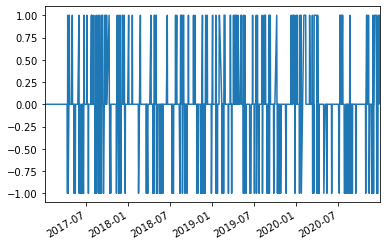

In [32]:
test_target_dict[list(test_target_dict.keys())[0]]['Signal_8'].plot()

## 单标的回测，绘图

In [33]:
import empyrical
import os



# 单标的回测曲线
def each_index_cumulative_returns_plot(test_index, signal_No, cost, folder_name):
    print('processing:', test_index)

    # 信号+回报调整
    adjusted_return = []
    trade_times = 0
    kk = 0
    winning_rate = []
    open_date = []
    close_date = []
    position_close_index_list = []
    train_end = test_target_dict[list(test_target_dict.keys())[0]].index[0]
    real_predict_corr = test_target_dict[test_index]['yvalid'].corr(test_target_dict[test_index]['open_to_open'])
    backtest_type = 'open_to_open'

    # 逐一标的计算收益
    for i in range(len(test_target_dict[test_index])):

        #         test_target_dict[test_index] = test_target_dict[test_index][~test_target_dict[test_index].index.duplicated()]

        # 初始化，第一笔交易
        # *float(Signal_X[i])是当前最新信号值，用于计算cost扣费方向
        Signal_X = test_target_dict[test_index][signal_No]

        if i == 0 and Signal_X[i] != 0:
            # 第一次交易，一定是从0变化， 如果不交易则signal = 0，如果交易则扣减掉 1*cost, 扣减方向
            adjusted_return.append(test_target_dict[test_index][backtest_type][i] - cost * float(Signal_X[i]))
            trade_times += 1
            open_date.append(i)

        # 如果产生交易（信号值变化），扣除手续费后，记录收益
        elif Signal_X[i - 1] != Signal_X[i]:

            # 1、平仓，扣减（上次仓位）手续费
            # 如果是平仓操作，记录平仓当日日期，并且当日的收益只是减少手续费
            if Signal_X[i] == 0:
                position_close_index_list.append(i)
                adjusted_return.append(0)
                trade_times += 1
                if i != 0:
                    close_date.append(i)

            # 2、开仓，扣减（本次仓位）手续费
            # 如果开仓，当日收益扣减掉带有方向的手续费
            elif Signal_X[i] != 0 and Signal_X[i - 1] == 0:
                adjusted_return.append(test_target_dict[test_index][backtest_type][i] - cost * (float(Signal_X[i])))
                trade_times += 1
                open_date.append(i)

            # 3、反手开仓，扣减双倍（本次仓位）手续费
            # 如果反手，一定是信号值-1， 1之间的转变，因此如果i- 1和i之间绝对值和为2的时候，则扣减掉两倍的手续费，当日收益方向为signal[i]的方向
            elif abs(Signal_X[i - 1]) + abs(Signal_X[i]) == 2:
                adjusted_return.append(test_target_dict[test_index][backtest_type][i] - 2 * cost * (float(Signal_X[i])))
                trade_times += 2
                close_date.append(i)
                open_date.append(i)

        # 如果信号值不变，记录收益
        else:
            adjusted_return.append(test_target_dict[test_index][backtest_type][i])


    # 如果最后一天仍有仓位，将最后一天作为平仓日
    if Signal_X[-1] != 0:
        close_date.append(len(test_target_dict[test_index]) - 1)


    # 带方向的每日回报序列
    test_target_dict[test_index]['final_return'] = adjusted_return * Signal_X

    # 对于只有平仓的日期，找出他们，把手续费扣除掉
    test_target_dict[test_index]['final_return'].iloc[position_close_index_list] = -cost


    # winrate_1_Day 计算
    try:
        winrate_1_Day = (test_target_dict[test_index][backtest_type] * Signal_X > 0).sum() / \
                        (test_target_dict[test_index][backtest_type] * Signal_X != 0).sum()
    except:
        winrate_1_Day = 0

    CumulativeReturns = ((1 + test_target_dict[test_index]['final_return']).cumprod() - 1)
    Annual_return = empyrical.annual_return(test_target_dict[test_index]['final_return'])
    Sharpe_ratio = empyrical.sharpe_ratio(test_target_dict[test_index]['final_return'])
    Max_drawdown = empyrical.max_drawdown(test_target_dict[test_index]['final_return'])


    # winning_rate 计算
    win_num = 0
    for j in range(len(open_date)):
        if CumulativeReturns[close_date[j] - 1] - CumulativeReturns[open_date[j] - 1] > 0:
            win_num += 1
    try:
        winning_rate = win_num / len(close_date)
    except:
        winning_rate = 0


    try:
        test_target_dict[test_index]['win_fail'] = winning_rate
    except:
        test_target_dict[test_index]['win_fail'] = [0 for _ in range(test_target_dict[test_index].shape[0])]
    #         try:
    #             win_array.append([test_index, winnum, failnum, winnum/(failnum+winnum)])
    #         except:
    #             win_array.append([test_index, winnum, failnum, 0.5])
    #         PortfolioWinnum = 0
    #         PortfolioFailnum = 0

    #     for i in range(len(win_array)):
    #         # 初始化
    #         PortfolioWinnum = PortfolioWinnum + win_array[i][1]
    #         PortfolioFailnum = PortfolioFailnum + win_array[i][2]

    #     try:
    #         PortfolioWinrate = PortfolioWinnum / (PortfolioWinnum + PortfolioFailnum)
    #     except:
    #         PortfolioWinrate = 0.5
    # print(win_array)
    # print('PortfolioWinnum:',PortfolioWinnum, 'PortfolioFailnum:',PortfolioFailnum, 'PortfolioWinrate:',PortfolioWinrate)

    PortfolioWinrate = winning_rate

    # 储存单标的绩效
    try:
        df = pd.read_csv('Return_detail_' + str(cost) + '.csv')
        del df['Unnamed: 0']
        index = '{}_{}_'.format(test_index, signal_No, 'real_predict_corr')
        df.loc[index] = [index, CumulativeReturns[-1], str(Sharpe_ratio)[:6], str(Max_drawdown)[:6], PortfolioWinrate,
                         trade_times, real_predict_corr]
        df.to_csv('Return_detail_' + str(signal_No) + str(cost) + '.csv')
    except:
        df = pd.DataFrame(dict.fromkeys(
            ['name', 'return', 'sharpe', 'maxDown', 'winrate', 'tradeTimes', 'real_predict_corr', 'winrate_1_Day'], []))
        index = '{}_{}_'.format(test_index, signal_No, 'real_predict_corr')
        df.loc[index] = [index, CumulativeReturns[-1], str(Sharpe_ratio)[:6], str(Max_drawdown)[:6], PortfolioWinrate,
                         trade_times, real_predict_corr, winrate_1_Day]
        df.to_csv('Return_detail_' + str(cost) + str(signal_No) + '.csv')

    idx = '{} {}'.format(test_index, signal_No)
    performance_df.loc[idx] = [Annual_return, Sharpe_ratio, Max_drawdown, trade_times, PortfolioWinrate,
                               real_predict_corr, winrate_1_Day]
    imgpath = folder_name + '\\{}_{}_{}.png'.format(test_index, signal_No, str(CumulativeReturns[-1])[:6])

    first_day = index_dict_ori_9999[test_index]['close'].loc[train_end:][index_dict_ori_9999[test_index]['close'] > 0][
        0]
    close_R = index_dict_ori_9999[test_index].loc[train_end:]['close'][
                  index_dict_ori_9999[test_index].loc[train_end:]['close'] > 0] / first_day
    print(imgpath)
    plt.plot(CumulativeReturns + 1, label='Net_Return')
    plt.plot(close_R, label=str(test_index))
    plt.legend()
    plt.savefig(imgpath)
    plt.clf()

    # 返回净值
    return CumulativeReturns + 1

## 信号6测试

In [35]:
# 运行回测，并绘图

try:
    folder_name = 'pictures_0401'
    os.mkdir(folder_name)
    print('创建目录',folder_name)
except:
    print('目录已创建，或者其他错误')
    pass

performance_df = pd.DataFrame()
performance_df['Annual Return'], performance_df['Sharpe Ratio'], performance_df['Max Drawdown'], performance_df[
    'Trading Times'] ,performance_df['PortfolioWinrate'] ,performance_df['real_predict_corr'], performance_df[
    'winrate_1_Day']= [],[],[],[],[],[],[]


PortfolioReturn = pd.DataFrame()

# 每个品种逐一绘图
for text_index in test_target_dict.keys():    
    
    CumulativeReturns = each_index_cumulative_returns_plot(text_index, 'Signal_8', 0.0002, folder_name)
    PortfolioReturn = pd.concat([PortfolioReturn, CumulativeReturns],axis = 1)

# 横向不同列相加，得到PortfolioReturn
PortfolioReturn.columns = test_target_dict.keys()
PortfolioReturn['PortfolioReturn'] =  PortfolioReturn.apply(lambda x:x.mean(),axis=1) 

目录已创建，或者其他错误
processing: AL
pictures_0401\AL_Signal_8_0.1023.png
processing: CU
pictures_0401\CU_Signal_8_0.2102.png
processing: ZN
pictures_0401\ZN_Signal_8_0.0890.png
processing: SN
pictures_0401\SN_Signal_8_-0.084.png
processing: NI
pictures_0401\NI_Signal_8_0.2926.png
processing: PB
pictures_0401\PB_Signal_8_-0.063.png
processing: AG
pictures_0401\AG_Signal_8_0.0407.png
processing: AU
pictures_0401\AU_Signal_8_0.1723.png
processing: RU
pictures_0401\RU_Signal_8_0.0443.png
processing: MA
pictures_0401\MA_Signal_8_0.7304.png
processing: PP
pictures_0401\PP_Signal_8_0.2459.png
processing: TA
pictures_0401\TA_Signal_8_0.2229.png
processing: L
pictures_0401\L_Signal_8_0.1810.png
processing: V
pictures_0401\V_Signal_8_0.2753.png
processing: BU
pictures_0401\BU_Signal_8_1.3100.png
processing: SC
pictures_0401\SC_Signal_8_0.6522.png
processing: FU
pictures_0401\FU_Signal_8_0.8840.png
processing: SP
pictures_0401\SP_Signal_8_0.2046.png
processing: UR
pictures_0401\UR_Signal_8_0.1125.png
pro

D:\anaconda\envs\alpha\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in longlong_scalars
D:\anaconda\envs\alpha\lib\site-packages\empyrical\stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,


<Figure size 432x288 with 0 Axes>

In [21]:
test_target_dict["LH"]

KeyError: 'LH'

In [19]:
each_index_cumulative_returns_plot("LH", 'Signal_8', 0.0002, folder_name)

processing: LH


KeyError: 'LH'

In [22]:
with open('test_target_dict_1日.pkl', 'rb') as f:
    test_target_dict = pickle.load(f)


In [23]:
test_target_dict.keys()

dict_keys(['AL', 'CU', 'ZN', 'SN', 'NI', 'PB', 'AG', 'AU', 'RU', 'MA', 'PP', 'TA', 'L', 'V', 'BU', 'SC', 'FU', 'SP', 'UR', 'EG', 'SA', 'EB', 'PG', 'PF', 'M', 'RM', 'P', 'Y', 'OI', 'C', 'CS', 'JD', 'SR', 'A', 'CF', 'AP', 'CJ', 'LH', 'HC', 'J', 'I', 'SF', 'RB', 'ZC', 'JM', 'SM', 'FG', 'SS'])

<AxesSubplot:>

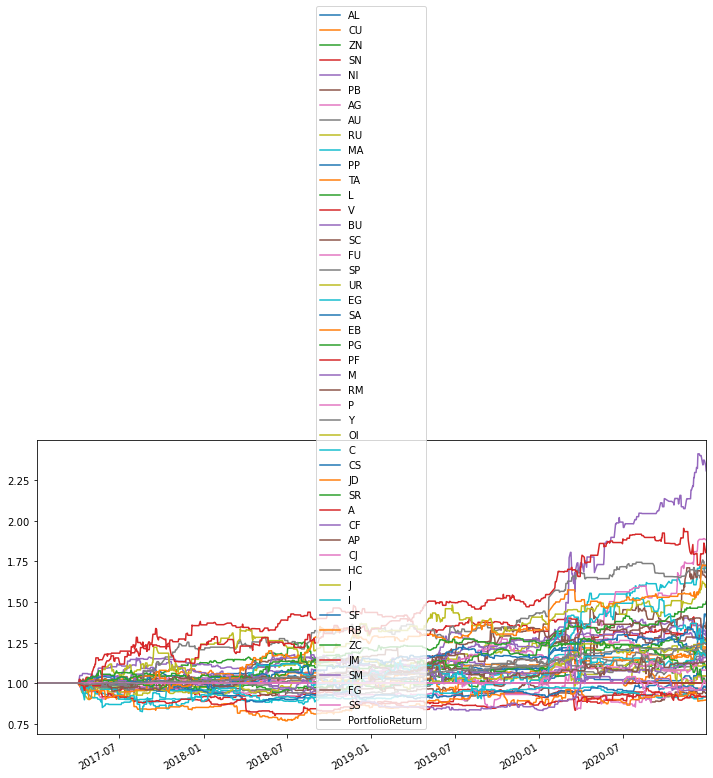

In [36]:
PortfolioReturn.plot(figsize = (12,6))

In [37]:
PortfolioReturn.tail()

,AL,CU,ZN,SN,NI,PB,AG,AU,RU,MA,...,J,I,SF,RB,ZC,JM,SM,FG,SS,PortfolioReturn
2020-12-23,1.108561,1.210286,1.123364,0.916007,1.327444,0.946455,1.041001,1.173618,1.044301,1.706113,...,1.615270,1.283573,1.366007,1.726901,1.003855,1.797780,1.157477,1.128966,0.996809,1.245006
2020-12-24,1.108339,1.210286,1.123140,0.915824,1.327178,0.946265,1.040793,1.173618,1.044301,1.706113,...,1.615270,1.247721,1.365733,1.726555,1.029784,1.863800,1.157477,1.128966,1.017485,1.246856
2020-12-25,1.108339,1.210286,1.123140,0.915824,1.327178,0.946265,1.040793,1.173618,1.044301,1.706113,...,1.615270,1.247472,1.425368,1.726555,1.029578,1.852803,1.157477,1.128966,1.017282,1.246173
2020-12-28,1.094353,1.210286,1.094059,0.915824,1.310753,0.936150,1.040793,1.173618,1.044301,1.706113,...,1.590942,1.247472,1.425083,1.723543,0.996530,1.804586,1.156984,1.134290,0.996107,1.238720
2020-12-29,1.102302,1.210286,1.089024,0.915824,1.292646,0.936936,1.040793,1.172306,1.044301,1.730441,...,1.605750,1.247472,1.410048,1.728196,1.007414,1.804225,1.156753,1.134063,0.999711,1.242387


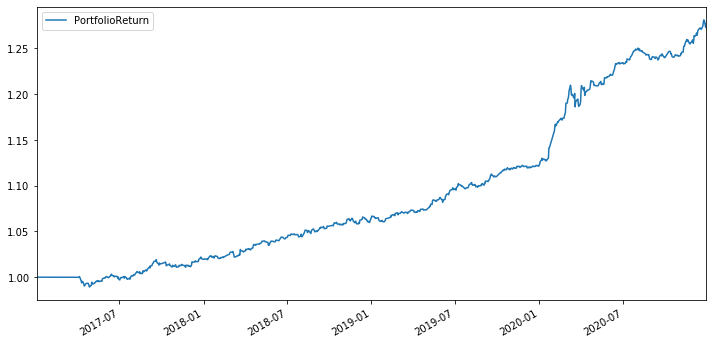

In [39]:
# 组合绩效
PortfolioReturn['PortfolioReturn'].plot(figsize = (12,6), label='PortfolioReturn')
plt.legend()

In [38]:
# 最终绩效
performance_df

,Annual Return,Sharpe Ratio,Max Drawdown,Trading Times,PortfolioWinrate,real_predict_corr,winrate_1_Day
AL Signal_8,0.025574,0.372980,-0.131004,374.0,0.529412,0.035151,0.535156
CU Signal_8,0.050726,0.738588,-0.068144,352.0,0.573864,0.058274,0.539370
ZN Signal_8,0.022356,0.283220,-0.182422,378.0,0.550265,0.059281,0.525926
SN Signal_8,-0.022539,-0.227911,-0.173032,290.0,0.475862,-0.004880,0.481633
NI Signal_8,0.068814,0.588999,-0.198207,410.0,0.570732,0.049935,0.544118
PB Signal_8,-0.016746,-0.137448,-0.172914,380.0,0.500000,0.018940,0.511029
AG Signal_8,0.010420,0.144387,-0.200293,346.0,0.514451,0.041385,0.525210
AU Signal_8,0.042076,0.671613,-0.095204,384.0,0.494792,0.044239,0.517110
RU Signal_8,0.011302,0.150674,-0.218523,358.0,0.597765,0.043015,0.567050
MA Signal_8,0.152774,1.073886,-0.169286,366.0,0.579235,0.102230,0.545802


In [39]:
# 绩效汇总
performance_df.mean()

Annual Return          0.052673
Sharpe Ratio           0.529758
Max Drawdown          -0.133680
Trading Times        300.595745
PortfolioWinrate       0.523203
real_predict_corr      0.060302
winrate_1_Day          0.543996
dtype: float64

In [ ]:
# 夏普和预测相关性的相关性
#performance_df['Sharpe Ratio'].corr(performance_df['real_predict_corr'])

In [ ]:
# 回报和预测相关性的相关性
# performance_df['Annual Return'].corr(performance_df['real_predict_corr'])

In [ ]:
# performance_df['real_predict_corr'].mean()